# EDA


=== ESV ===
count    10024.000000
mean      1441.569733
std        536.891720
min        147.500000
25%       1082.500000
50%       1331.750000
75%       1684.000000
max       6154.000000
Name: area, dtype: float64 



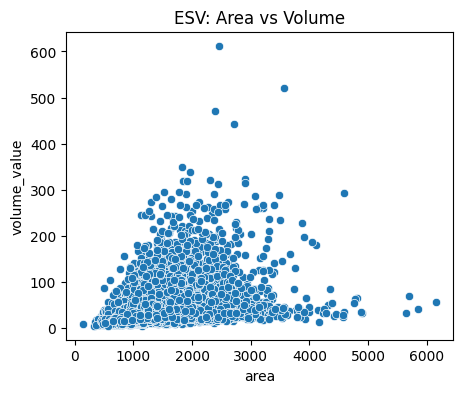

ESV correlation: 0.321

=== EDV ===
count    10024.000000
mean       872.448374
std        392.125793
min          9.500000
25%        614.500000
50%        778.250000
75%       1036.625000
max       4179.000000
Name: area, dtype: float64 



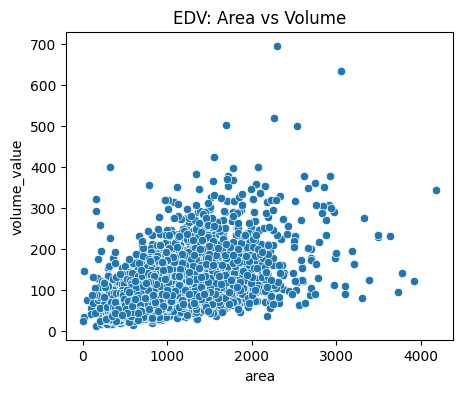

EDV correlation: 0.534


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load
df = pd.read_csv("../data/regressor_dataset.csv")

# Separate ESV and EDV data
esv_df = df[df["volume_type"] == "esv"]
edv_df = df[df["volume_type"] == "edv"]

for name, dfi in [("ESV", esv_df), ("EDV", edv_df)]:
    print(f"\n=== {name} ===")
    print(dfi["area"].describe(), "\n")
    # Scatter plot
    plt.figure(figsize=(5,4))
    sns.scatterplot(x="area", y="volume_value", data=dfi)
    plt.title(f"{name}: Area vs Volume")
    plt.show()
    corr = dfi[["area","volume_value"]].corr().iloc[0,1]
    print(f"{name} correlation: {corr:.3f}")


# Training

In [9]:
!pip install xgboost --quiet

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import pandas as pd
import numpy as np

# Simulated dataset loading
df = pd.read_csv('../data/regressor_dataset.csv')  # Example path
esv_data = df[df['volume_type'] == 'esv']
edv_data = df[df['volume_type'] == 'edv']

# Prepare features and labels
X_esv = esv_data[['area']]
y_esv = esv_data['volume_value']
X_edv = edv_data[['area']]
y_edv = edv_data['volume_value']

# Train-test split
X_train_esv, X_test_esv, y_train_esv, y_test_esv = train_test_split(X_esv, y_esv, test_size=0.2, random_state=42)
X_train_edv, X_test_edv, y_train_edv, y_test_edv = train_test_split(X_edv, y_edv, test_size=0.2, random_state=42)

# Hyperparameter grid
param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 5),
    'reg_lambda': uniform(0, 5)
}

# Regressors
xgb_esv = XGBRegressor(random_state=42)
xgb_edv = XGBRegressor(random_state=42)

# Random search CV
random_search_esv = RandomizedSearchCV(
    xgb_esv,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=50,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search_edv = RandomizedSearchCV(
    xgb_edv,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=50,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit models
random_search_esv.fit(X_train_esv, y_train_esv)
random_search_edv.fit(X_train_edv, y_train_edv)


Fitting 50 folds for each of 50 candidates, totalling 2500 fits
Fitting 50 folds for each of 50 candidates, totalling 2500 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': <scipy.stats....x74dc11cdf5b0>, 'gamma': <scipy.stats....x74dc11cdc9d0>, 'learning_rate': <scipy.stats....x74dbb9c0f370>, 'max_depth': <scipy.stats....x74dbe116cf40>, ...}"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,50
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:

# Evaluate
best_esv_model = random_search_esv.best_estimator_
y_pred_esv = best_esv_model.predict(X_test_esv)
rmse_esv = root_mean_squared_error(y_test_esv, y_pred_esv)
r2_esv = r2_score(y_test_esv, y_pred_esv)

best_edv_model = random_search_edv.best_estimator_
y_pred_edv = best_edv_model.predict(X_test_edv)
rmse_edv = root_mean_squared_error(y_test_edv, y_pred_edv)
r2_edv = r2_score(y_test_edv, y_pred_edv)

print(f'ESV RMSE: {rmse_esv}')
print(f'ESV R2: {r2_esv}')
print(f'ESV Params: {random_search_esv.best_params_}\n\n')
print(f'EDV RMSE: {rmse_edv}')
print(f'EDV R2: {r2_edv}')
print(f'EDV Params: {random_search_edv.best_params_}')


ESV RMSE: 33.07533962896938
ESV R2: 0.12864842242656294
ESV Params: {'colsample_bytree': np.float64(0.7902634929450308), 'gamma': np.float64(1.424202471887338), 'learning_rate': np.float64(0.021066084206359838), 'max_depth': 3, 'n_estimators': 101, 'reg_alpha': np.float64(2.5133951161443076), 'reg_lambda': np.float64(0.25739375624994676), 'subsample': np.float64(0.7835939392709834)}


EDV RMSE: 36.971112252547165
EDV R2: 0.32453019056131915
EDV Params: {'colsample_bytree': np.float64(0.7902634929450308), 'gamma': np.float64(1.424202471887338), 'learning_rate': np.float64(0.021066084206359838), 'max_depth': 3, 'n_estimators': 101, 'reg_alpha': np.float64(2.5133951161443076), 'reg_lambda': np.float64(0.25739375624994676), 'subsample': np.float64(0.7835939392709834)}


🔹 ESV RMSE: 33.08
🔹 ESV R²: 0.13
🔹 ESV Best Params: {'colsample_bytree': np.float64(0.7902634929450308), 'gamma': np.float64(1.424202471887338), 'learning_rate': np.float64(0.021066084206359838), 'max_depth': 3, 'n_estimators': 101, 'reg_alpha': np.float64(2.5133951161443076), 'reg_lambda': np.float64(0.25739375624994676), 'subsample': np.float64(0.7835939392709834)}

🔹 EDV RMSE: 36.97
🔹 EDV R²: 0.32
🔹 EDV Best Params: {'colsample_bytree': np.float64(0.7902634929450308), 'gamma': np.float64(1.424202471887338), 'learning_rate': np.float64(0.021066084206359838), 'max_depth': 3, 'n_estimators': 101, 'reg_alpha': np.float64(2.5133951161443076), 'reg_lambda': np.float64(0.25739375624994676), 'subsample': np.float64(0.7835939392709834)}


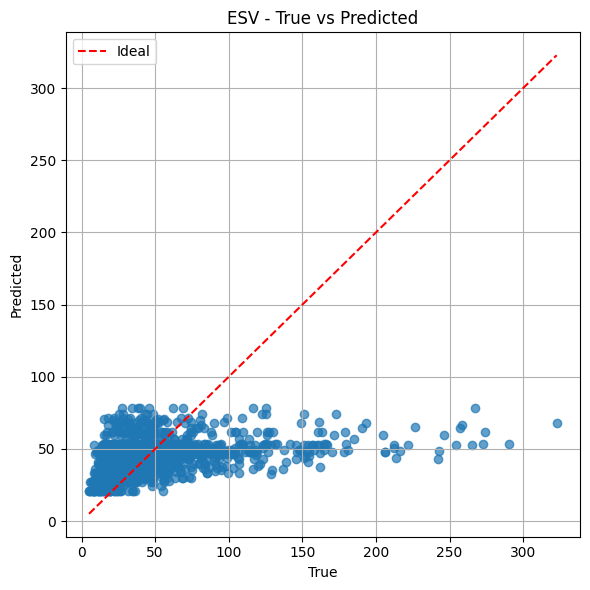

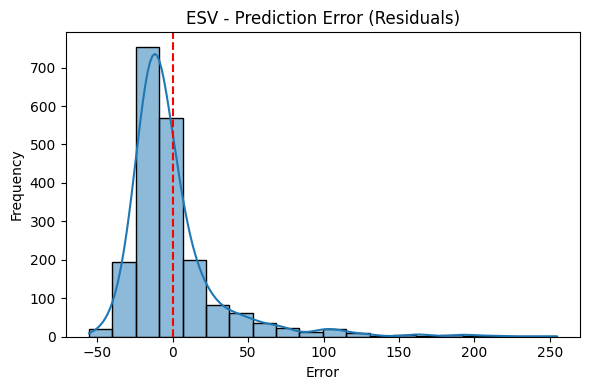

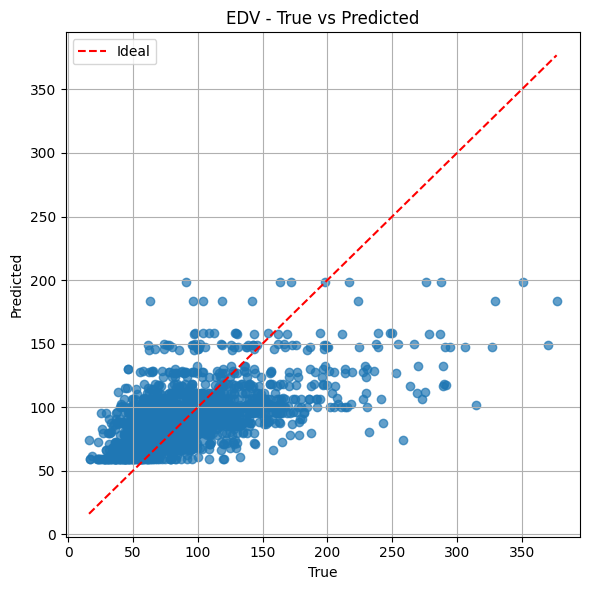

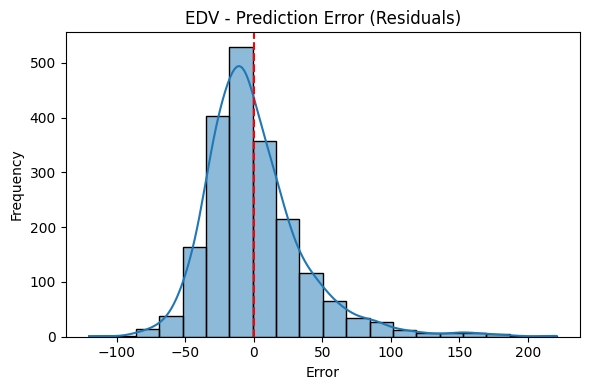

In [ ]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, r2_score

# === 1. Save models ===
joblib.dump(best_esv_model, '../models/best_esv_model.pkl')
joblib.dump(best_edv_model, '../models/best_edv_model.pkl')

# (Optional) To load later
# best_esv_model = joblib.load('best_esv_model.pkl')
# best_edv_model = joblib.load('best_edv_model.pkl')

# === 2. Predictions ===
y_pred_esv = best_esv_model.predict(X_test_esv)
y_pred_edv = best_edv_model.predict(X_test_edv)

# === 3. Evaluation ===
rmse_esv = root_mean_squared_error(y_test_esv, y_pred_esv)
r2_esv = r2_score(y_test_esv, y_pred_esv)

rmse_edv = root_mean_squared_error(y_test_edv, y_pred_edv)
r2_edv = r2_score(y_test_edv, y_pred_edv)

print(f'🔹 ESV RMSE: {rmse_esv:.2f}')
print(f'🔹 ESV R²: {r2_esv:.2f}')
print(f'🔹 ESV Best Params: {random_search_esv.best_params_}\n')

print(f'🔹 EDV RMSE: {rmse_edv:.2f}')
print(f'🔹 EDV R²: {r2_edv:.2f}')
print(f'🔹 EDV Best Params: {random_search_edv.best_params_}')

# === 4. Plots ===
def plot_true_vs_pred(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"{title} - True vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, bins=20, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"{title} - Prediction Error (Residuals)")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# ESV Plots
plot_true_vs_pred(y_test_esv, y_pred_esv, "ESV")
plot_residuals(y_test_esv, y_pred_esv, "ESV")

# EDV Plots
plot_true_vs_pred(y_test_edv, y_pred_edv, "EDV")
plot_residuals(y_test_edv, y_pred_edv, "EDV")
